# Regularization and Dropout

In this notebook, we will analyze the regularization and dropout effect in the results of a neural network used to classify pieces of clothing in the well-known Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist). 

Let's start loading the neecssary libraries:
* Pytorch
* Numpy
* Torchvision to load the data
* Matplotlib to plot results and images
* 

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as tr
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import confusion_matrix

## Load the data

The library torchvision is used to load the Fashion-MNIST dataset and then is transformed into tensors that can be used by the torch library. The tensors with the data will be fetched using a dataloader.



In [2]:
all_tr = tr.Compose([tr.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=all_tr)

test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=all_tr)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # The batch size is 5 but can be increase to better performance.
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True) 

Images in the dataset and its labels:

Label: 3
Label: Dress


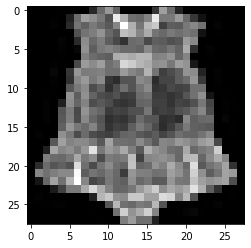

In [3]:
# The dataloader will return a iterable over the Fashion-MNIST dataset. Each batch have a set of images (28x28) and its label 
images, labels = next(iter(train_dataloader))

image = images[0]
label = labels[0]

plt.imshow(image.squeeze(), cmap="gray")
print(f'Label: {label.item()}')

# The labels need to be transformed to teh correct description:
lbl_mapping = {0: 'T-shirt/top', 1:	'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
print(f'Label: {lbl_mapping[label.item()]}')

## The Neural Network

In [4]:
# We create a new class "FFNetwork" from nn.Module that implement a simple Feed Forward Network
class FFNetwork(nn.Module):
    # Constructor
    def __init__(self):
        super().__init__()

        # A single hidden layer with 100 units
        self.layers = nn.Sequential(
            nn.Flatten(),        # Convert 28 x 28 images into a flat tensor
            nn.Linear(784, 100), # 28 x 28 = 784 inputs; 100 outputs
            nn.ReLU(),           # Add ReLU activation
            nn.Linear(100, 10)   # 100 inputs; 10 outputs (10 classes: 'T-shirt/top', 'Trouser', 'Pullover', ..., 'Ankle boot')
        )

    # Forward method  
    def forward(self, x): 
        # with the input "x" evaluet it in the layers of teh network
        out = self.layers(x)
        return out

Without training, what is the prediction of the network?

In [5]:
# Create an instance of the network
ffnet = FFNetwork()

# Run the sample through the network
output = ffnet(images)

# Let's check the first 10 classification
for i in range(10): #output.shape[0]
    y_hat = torch.argmax(output[i, :]).item()
    y = labels[i].item()
    print(f'Image {i}')
    print(f'Predited label: {lbl_mapping[y_hat]}')
    print(f'Actual label: {lbl_mapping[y]}')

Image 0
Predited label: Coat
Actual label: Dress
Image 1
Predited label: Coat
Actual label: Ankle boot
Image 2
Predited label: Coat
Actual label: Pullover
Image 3
Predited label: Coat
Actual label: T-shirt/top
Image 4
Predited label: Pullover
Actual label: T-shirt/top
Image 5
Predited label: Pullover
Actual label: T-shirt/top
Image 6
Predited label: Pullover
Actual label: Sandal
Image 7
Predited label: Pullover
Actual label: Sneaker
Image 8
Predited label: Pullover
Actual label: Sneaker
Image 9
Predited label: Pullover
Actual label: Sneaker


## Train the network

   Training epoch: 0
   Training epoch: 1
   Training epoch: 2
   Training epoch: 3
   Training epoch: 4
   Training epoch: 5
   Training epoch: 6
   Training epoch: 7
   Training epoch: 8
   Training epoch: 9
   Training epoch: 10
   Training epoch: 11
   Training epoch: 12
   Training epoch: 13
   Training epoch: 14
   Training epoch: 15
   Training epoch: 16
   Training epoch: 17
   Training epoch: 18
   Training epoch: 19


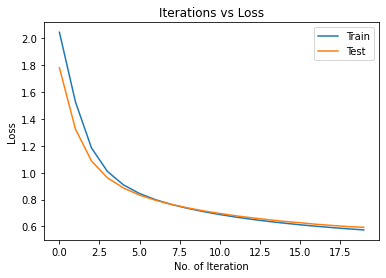

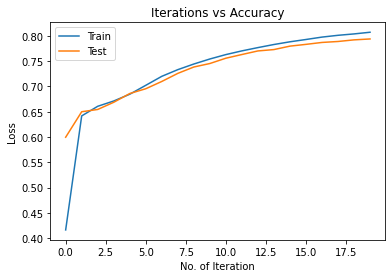

In [6]:
def get_predictions(model, dataloader, loss_function=nn.CrossEntropyLoss()):
    with torch.no_grad():
        y_hat = torch.tensor([])
        y = torch.tensor([])

        loss = []

        for image, label in dataloader:
            output = model(image)
            l = loss_function(output, label)
            loss.append(l)

  
            # Add them to the tensor
            y_hat = torch.cat((y_hat, output.argmax(1)), dim=0)
            y = torch.cat((y, label), dim=0)

    return y_hat, y, torch.tensor(loss).mean().item()



def train(model, train_dataloader, test_dataloader, epochs, loss_function, optimizer):
    
    # Reset data loader
    iter(train_dataloader)
    iterations = []
    train_loss = []
    train_accuracy = []
    test_accurancy = []
    test_loss = []
    for ep in range(epochs):
        print(f'   Training epoch: {ep}')
        
        # Keep track of the loss during training
        batch_loss = []
        batch_accuracy = []
        

        # We use our data loader to fetch batches from our dataset
        for Xbatch, ybatch in train_dataloader:

            # We first zero-out the gradients
            optimizer.zero_grad()
            
            # Compute output
            output = ffnet(Xbatch)

            # Get loss
            l = loss_function(output, ybatch)

            # # Get Accuracy
            a = (output.argmax(1) == ybatch).sum() / len(ybatch) #* 100 


            # Compute gradients
            l.backward()

            # Perform optimization step
            optimizer.step()

            batch_loss.append(l)
            batch_accuracy.append(a)

        iterations.append(ep)
        train_loss.append(torch.tensor(batch_loss).mean().item())
        train_accuracy.append(torch.tensor(batch_accuracy).mean().item())

        test_y_hat, test_y, t_lost = get_predictions(model, test_dataloader, loss_function)
        test_loss.append(t_lost)
        t_accurancy = (test_y_hat == test_y).sum() / len(test_y)
        test_accurancy.append(t_accurancy)
        
        # print(f'    Training loss: %.4f' % torch.tensor(batch_loss).mean().item())
        # print(f'Training accuracy: %.4f' % torch.tensor(batch_accuracy).mean().item())
        # print(f'        Test loss: %.4f' % t_lost)
        # print(f'    Test accuracy: %.4f' % t_accurancy)

    return iterations, train_loss, train_accuracy, test_loss, test_accurancy

EPOCHS = 20
loss = nn.CrossEntropyLoss()

# Define the optimizer. We indicate:
#   - What is being optimized (the parameters of the network)
#   - The learning rate 
optimizer = torch.optim.SGD(ffnet.parameters(), lr=0.001)

iterations, train_loss, train_accuracy, test_loss, test_accurancy = train(ffnet, train_dataloader, test_dataloader, EPOCHS, loss, optimizer)

plt.plot(iterations, train_loss, label="Train")
plt.plot(iterations, test_loss, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.legend()
plt.show()

plt.plot(iterations, train_accuracy, label="Train")
plt.plot(iterations, test_accurancy, label="Test" )
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Accuracy")
plt.legend()
plt.show()

In [7]:
# Use the test dataset
images, labels = next(iter(test_dataloader))

# Run the sample through the network
output = ffnet(images)

# Let's check the first 10 classification
for i in range(10): #output.shape[0]
    y_hat = torch.argmax(output[i, :]).item()
    y = labels[i].item()
    print(f'         Image: {i}')
    print(f'Predited label: {lbl_mapping[y_hat]}')
    print(f'  Actual label: {lbl_mapping[y]}')


         Image: 0
Predited label: T-shirt/top
  Actual label: T-shirt/top
         Image: 1
Predited label: Bag
  Actual label: Shirt
         Image: 2
Predited label: Dress
  Actual label: Dress
         Image: 3
Predited label: Dress
  Actual label: Dress
         Image: 4
Predited label: Coat
  Actual label: Coat
         Image: 5
Predited label: Ankle boot
  Actual label: Ankle boot
         Image: 6
Predited label: Sneaker
  Actual label: Sneaker
         Image: 7
Predited label: Sneaker
  Actual label: Sneaker
         Image: 8
Predited label: Shirt
  Actual label: Pullover
         Image: 9
Predited label: Bag
  Actual label: Shirt


XXXXXXXXXX

In [8]:

# Reset data loaders
iter(train_dataloader)
iter(test_dataloader)

# Train 
y_hat, y, train_lost = get_predictions(ffnet, train_dataloader)
cm_test = confusion_matrix(y_true=y, y_pred=y_hat)
print(cm_test)

accuracy = (y_hat == y).sum() / len(y)
print('Train Accuracy:', accuracy.item())
print('Train lost:', torch.tensor(train_lost).mean().item())

# Test 
y_hat, y, test_lost = get_predictions(ffnet, test_dataloader)
cm_test = confusion_matrix(y_true=y, y_pred=y_hat)
print(cm_test)

accuracy = (y_hat == y).sum() / len(y)
print('Test Accuracy:', accuracy.item())
print('Test lost:', torch.tensor(test_lost).mean().item())
        


[[4817   79   68  427   29    5  464    1  108    2]
 [   8 5635  118  195   21    0   21    0    2    0]
 [  44   18 3854   45 1178    1  781    0   78    1]
 [ 238  108   34 5082  233    1  277    0   27    0]
 [   5   19  440  220 4715    2  550    0   48    1]
 [   7    1    2    6    1 4969    0  635   43  336]
 [1046   31  706  211  826    1 3018    1  159    1]
 [   0    0    0    0    0  192    0 5308   14  486]
 [  10    5   34   62   35   39  160   38 5608    9]
 [   1    1    1    1    0   78    4  363    5 5546]]
Train Accuracy: 0.8091999888420105
Train lost: 0.5708541870117188
[[779  11  12  73   5   1  98   0  21   0]
 [  5 932  14  39   8   0   0   0   2   0]
 [ 15   2 619   9 196   1 143   0  15   0]
 [ 33  15   4 826  41   1  76   0   4   0]
 [  0   2  89  31 755   0 116   0   7   0]
 [  1   0   0   1   0 803   0 120   5  70]
 [183   4 130  40 141   0 466   0  36   0]
 [  0   0   0   0   0  32   0 890   0  78]
 [  0   1  11  11   2   9  24   5 936   1]
 [  0   0   0   